In [3]:
# import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
import numpy as np
import seaborn as sns
from IPython import get_ipython
import shutil
import glob
from tqdm import tqdm 
from PIL import Image
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

In [2]:
#if data is stored in google drive, use this. else pleas dont run this cell
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
path_to_demo='/content/drive/MyDrive/final_project/demo/' #please enter the path to the demo folder as shown here
l1_train = path_to_demo+'l1-train/'
l2_train = path_to_demo+'l2-train/'
l1_test = path_to_demo+'l1-test/'
l2_test = path_to_demo+'l2-test/'
l1_search = path_to_demo+'l1-search/'
l2_search = path_to_demo+'l2-search/'

In [4]:
#creates stadard deviation image
def std_edge_img(train_img):
  x_train = np.array(train_img, np.float32)
  std_img = np.std(x_train, axis=0)
  edges = cv2.Canny(np.uint8(std_img),209,210)
  blackto3d = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
  blackto3d[edges==0] = (0,0,0)
  return blackto3d

In [5]:
#canny edge detector
def canny_edge(image):
  img2=cv2.Canny(np.uint8(image),209,210)#converting the black of checking image to green
  blacktogreen2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
  blacktogreen2[img2==0] = (10,255,10)
  return blacktogreen2

In [7]:
#creates canny edge for mean image
def mean_edge_img(train_img):
  x_train = np.array(train_img, np.float32)
  mean_img_l = np.mean(x_train, axis=0)
  img2=canny_edge(mean_img_l)
  return img2


In [8]:
#calculates %match between two images
def ret_limit(image1,image2):
  res = cv2.absdiff(image1, image2)
  res = res.astype(np.uint8)
  percentage = (np.count_nonzero(res) * 100)/ res.size
  return percentage

In [20]:
#creates mean for the provided images
#make sure that there is a folder called mean in all test,train,search folders, here a background image will be saved
def create_mean(path,name):
  train_img = []
  mean_img=''
  mean_image_pics=[]
  for img_path in tqdm(glob.glob(path+name+"/*.jpg")):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512,512))
    train_img.append(img)
  train_img = np.array(train_img, np.float32)

  image1 = np.asarray(std_edge_img(train_img), np.float64)
  image2 = np.asarray(mean_edge_img(train_img), np.float64)

  limit = 100-ret_limit(image1,image2)
  print(limit)
  for image in tqdm(train_img):
    image2 = np.asarray(canny_edge(image), np.float64)
    x =100-ret_limit(image1,image2)
    if x<=limit:
      print(x)
      mean_image_pics.append(image)

  mean_img = np.mean(mean_image_pics, axis=0)
  #saving as npy, since its a numpy matrix
  np.save(path+name+"/mean/"+name+"-mean.npy", mean_img)    # .npy extension is added if not given
  cv2.imwrite("/content/mean.jpg",mean_img,[cv2.IMWRITE_JPEG_QUALITY, 100])
  return "done"


In [79]:
#returns no of images belonging to the same location and no.of images with animals along with their image number
def show_animal(path,name,name2):
  black_img = np.zeros((512, 512,3), dtype = "uint8")
  ret=[]
  print(path+name+"/mean/"+name+"-mean.npy")
  image_mean=np.load(path+name+"/mean/"+name+"-mean.npy")
  imgs=[]
  paths=[]
  path_store=[]
  print(path+name2+"/*.jpg")
  for img_path in tqdm(glob.glob(path+name2+"/*.jpg")):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512,512))
    imgs.append(img)
    paths.append(img_path)
  #imgs = np.array(imgs, np.float32)
  image1=np.asarray(image_mean,np.float64)
  i=0
  count=0
  for image in imgs:
    image2=np.asarray(image,np.float64)
    res=cv2.absdiff(image1,image2)
    res = res.astype(np.uint8)
    result = cv2.threshold(res, 0, 25.5, cv2.THRESH_BINARY)[1]
    x=100-ret_limit(black_img,result)
    #x=ret_limit(image1,image2)
    if (x>5.5):
      count+=1
    else:
      path_store.append(paths[i])
    if x>5.5and x<9:
      g = paths[i]
      ret.append(g)
      #print('image-'+str(i+1)+'.jpg')
    i+=1
  print('\n-------------------------------------------images from same location-----------------------------------------------\n')
  print(str(count)+" images of "+name2+" are from same location as "+ name)
  print('\nimages in '+name2+' that does not belong to '+name+' are:\n')
  for path in path_store:
    print(path)
  return ret

In [72]:
#used for seaerching to which location the images in search folder belongs
def check_upload(path,names,img):
  black_img = np.zeros((512, 512,3), dtype = "uint8")
  ret = ""
  img = cv2.imread(img)
  img = cv2.resize(img, (512,512))
  for name in names:
    image_mean=np.load(path+name+"/mean/"+name+"-mean.npy")
    image1=np.asarray(image_mean,np.float64)
    image2=np.asarray(img,np.float64)
    res=cv2.absdiff(image1,image2)
    res = res.astype(np.uint8)
    result = cv2.threshold(res, 0,25.5, cv2.THRESH_BINARY)[1]
    x=100-ret_limit(black_img,result)
    if x>5.5:
      ret=name
      break
  return ret

In [81]:
#creating mean for l1 train and l2 train
print(create_mean(path_to_demo,'l1-train'))
print(create_mean(path_to_demo,'l2-train'))

100%|██████████| 25/25 [00:01<00:00, 13.14it/s]


0.2651214599609375


 24%|██▍       | 6/25 [00:00<00:00, 52.48it/s]

0.2429962158203125
0.2363840738932339
0.2493540445963589
0.2241770426432339
0.2460479736328125
0.2465565999348911


 72%|███████▏  | 18/25 [00:00<00:00, 51.34it/s]

0.2407073974609375
0.2447764078776089
0.2381642659505161
0.2480824788411411
0.2340952555338589
0.2544403076171875
0.2503712972005161
0.2498626708984375
0.2384185791015625
0.2348581949869839
0.2409617106119839

100%|██████████| 25/25 [00:00<00:00, 49.77it/s]



0.2506256103515625
0.2414703369140625
done


100%|██████████| 25/25 [00:01<00:00, 18.47it/s]


0.7074991861979214


 24%|██▍       | 6/25 [00:00<00:00, 52.40it/s]

0.4834493001302036
0.5572001139322964
0.5452473958333286
0.5648295084635464
0.5620320638020786
0.5551656087239536
0.5574544270833286
0.5368550618489536
0.5521138509114536
0.5566914876302036
0.6045023600260464


 72%|███████▏  | 18/25 [00:00<00:00, 47.79it/s]

0.6235758463541714
0.6281534830729214
0.68359375
0.6863911946614536
0.6940205891927036
0.6810506184895786
0.6734212239583286
0.6978352864583286
0.5910237630208286
0.583648681640625


100%|██████████| 25/25 [00:00<00:00, 47.86it/s]


0.5238850911458286
0.513458251953125
0.5025227864583286
0.5017598470052036
done


In [80]:
#searching in l1 test and l2 test using the backgroung image generated.
#changing parameters here we can compare different results.
#syntax = path,name,name2.
#where path- path to folder, name- folder for which mean is already calculated, name2- folder which we want to check
#once returned, the images have to be manually verified.
animal_images=show_animal(path_to_demo,'l1-train','l1-test')
print('-----------------------------------------------Images with animals------------------------------------------------')
print('\n'+str(len(animal_images))+' images contain animal. the paths for the images are:\n')
for path in animal_images:
  print(path)

/content/drive/MyDrive/final_project/demo/l1-train/mean/l1-train-mean.npy
/content/drive/MyDrive/final_project/demo/l1-test/*.jpg


100%|██████████| 25/25 [00:01<00:00, 12.68it/s]



-------------------------------------------images from same location-----------------------------------------------

25 images of l1-test are from same location as l1-train

images in l1-test that does not belong to l1-train are:

-----------------------------------------------Images with animals------------------------------------------------

6 images contain animal. the paths for the images are:

/content/drive/MyDrive/final_project/demo/l1-test/image-1.jpg
/content/drive/MyDrive/final_project/demo/l1-test/image-5.jpg
/content/drive/MyDrive/final_project/demo/l1-test/image-7.jpg
/content/drive/MyDrive/final_project/demo/l1-test/image-14.jpg
/content/drive/MyDrive/final_project/demo/l1-test/image-15.jpg
/content/drive/MyDrive/final_project/demo/l1-test/image-23.jpg


In [77]:
#here we use the images from l1-search, l2-search and see to which location each image belongs
name = ['l1-train','l2-train']#names of the folders which we calculated the background image
print('-----------------------------------------------Images with animals------------------------------------------------')
for names in glob.glob(path_to_demo+'l1-search'+'/*.jpg'):
  print(names +' belongs to location **'+check_upload(path_to_demo,name,names)+'**')
print('\n')
for names in glob.glob(path_to_demo+'l2-search'+'/*.jpg'):
  print(names +' belongs to location **'+check_upload(path_to_demo,name,names)+'**')

-----------------------------------------------Images with animals------------------------------------------------
/content/drive/MyDrive/final_project/demo/l1-search/image-1.jpg belongs to location **l1-train**
/content/drive/MyDrive/final_project/demo/l1-search/image-2.jpg belongs to location **l1-train**
/content/drive/MyDrive/final_project/demo/l1-search/image-3.jpg belongs to location **l1-train**
/content/drive/MyDrive/final_project/demo/l1-search/image-4.jpg belongs to location **l1-train**
/content/drive/MyDrive/final_project/demo/l1-search/image-5.jpg belongs to location **l1-train**
/content/drive/MyDrive/final_project/demo/l1-search/image-6.jpg belongs to location **l1-train**


/content/drive/MyDrive/final_project/demo/l2-search/image-1.jpg belongs to location **l2-train**
/content/drive/MyDrive/final_project/demo/l2-search/image-2.jpg belongs to location **l2-train**
/content/drive/MyDrive/final_project/demo/l2-search/image-3.jpg belongs to location **l2-train**
/content/d

In [16]:
#checking how normalization effects in camera trap setting
#reading the images into lists  (for location-1, y = one and so on)
train_img = [] #stores the images
class_name=[] #stores the class names
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512,512))
    return img

from tqdm import tqdm 

for img_path in tqdm(glob.glob('/content/drive/MyDrive/final_project/demo/l1-test/*.jpg')):
    train_img.append(read_img(img_path))
    class_name.append('one')
for img_path in tqdm(glob.glob('/content/drive/MyDrive/final_project/demo/l1-train/*.jpg')):
    train_img.append(read_img(img_path))
    class_name.append('one')

for img_path in tqdm(glob.glob('/content/drive/MyDrive/final_project/demo/l2-test/*.jpg')):
    train_img.append(read_img(img_path))
    class_name.append('two')
for img_path in tqdm(glob.glob('/content/drive/MyDrive/final_project/demo/l2-train/*.jpg')):
    train_img.append(read_img(img_path))
    class_name.append('two')
x_train = np.array(train_img, np.float32)


100%|██████████| 25/25 [00:01<00:00, 16.34it/s]


(512, 512, 3)
(512, 512, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


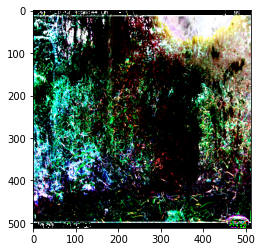

In [34]:
#dividing with 255 cause rgb values lie in the range of 0-255 so changing it to 0-1 by dividing
x_train = np.array(train_img, np.float32)/ 255.
#and normalising the data
mean_img = np.mean(x_train, axis=0)
print(mean_img.shape)
std_img = np.std(x_train, axis=0)
print(std_img.shape)
x_train_norm = (x_train - mean_img) / std_img
x_train_norm.shape
plt.imshow(x_train_norm[1])

In [26]:
Y_train = {i:x for x,i in enumerate(set(class_name))}
y_train = [Y_train[i] for i in class_name]
print(y_train)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [27]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
print(y_train.shape)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model



(100, 2)


In [37]:
#Creating the CNN
model = Sequential()
model.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (512,512,3)))

model.add(Convolution2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(256, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Convolution2D(512, (3,3), activation='relu', padding='same'))
model.add(Convolution2D(512, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.05), metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 512, 512, 32)      896       
                                                                 
 conv2d_41 (Conv2D)          (None, 510, 510, 32)      9248      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 255, 255, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 255, 255, 64)      18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 126, 126, 64)     0         
 g2D)                                                 

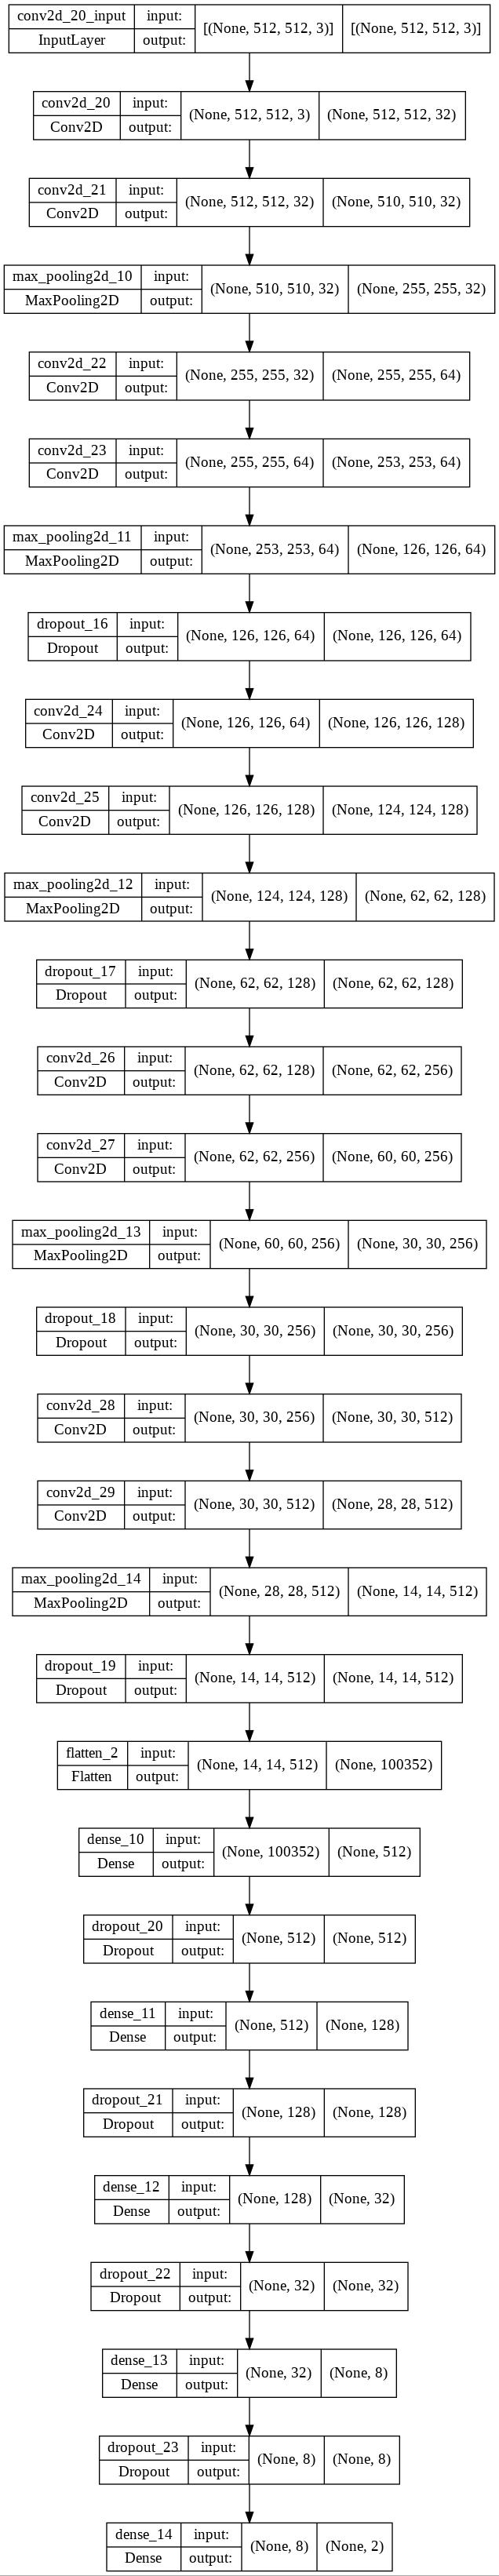

In [29]:
plot_model(model, to_file='/content/model_plot.jpg', show_shapes=True, show_layer_names=True)# showing model structure

In [38]:
early_stops = EarlyStopping(patience=5, monitor='val_loss')


In [36]:
#please make sure the data in shuffeled in both x_train_norm, y_train 
# after running this, run the cell where the model is created and leave this cell and run the cell below
#this uses normalized data
#the cell below uses non normalized data
#the accuracy can be different since only using 100 images (overfitting or underfitting). use the whole data for bette results
model.fit(x_train_norm, y_train, batch_size=25, epochs=10, validation_split=0.2, callbacks=[early_stops])

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 214s 3s/sample - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 188s 2s/sample - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.0000e+00
Epoch 3/10
80/80 [==============================] - 185s 2s/sample - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.0000e+00
Epoch 4/10
80/80 [==============================] - 194s 2s/sample - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.0000e+00
Epoch 5/10
80/80 [==============================] - 185s 2s/sample - loss: nan - acc: 0.6250 - val_loss: nan - val_acc: 0.0000e+00


In [39]:
#please make sure the data in shuffeled in both x_train, y_train 
model.fit(x_train, y_train, batch_size=25, epochs=10, validation_split=0.2, callbacks=[early_stops])

Train on 80 samples, validate on 20 samples
Epoch 1/10
80/80 [==============================] - 189s 2s/sample - loss: 10663784508588.0801 - acc: 0.5000 - val_loss: 59317.6758 - val_acc: 0.0000e+00
Epoch 2/10
80/80 [==============================] - 196s 2s/sample - loss: 172988877.6101 - acc: 0.5875 - val_loss: 4.8767 - val_acc: 0.0000e+00
Epoch 3/10
80/80 [==============================] - 187s 2s/sample - loss: 33008.3243 - acc: 0.6000 - val_loss: 20.0425 - val_acc: 0.0000e+00
Epoch 4/10
80/80 [==============================] - 187s 2s/sample - loss: 12.7850 - acc: 0.6125 - val_loss: 0.1311 - val_acc: 1.0000
Epoch 5/10
80/80 [==============================] - 192s 2s/sample - loss: 58.3847 - acc: 0.5750 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/10
80/80 [==============================] - 189s 2s/sample - loss: 2239762893199.2603 - acc: 0.5125 - val_loss: 39.8944 - val_acc: 0.0000e+00
Epoch 7/10
80/80 [==============================] - 190s 2s/sample - loss: 230264294016.0000 